## 问题描述：

利用numpy搭建全连接神经网络，使用numpy 实现此练习需要自己手动求导。



## 数据集:

MNIST数据集包括60000张训练图片和10000张测试图片。图片样本的数量已经足够训练一个很复杂的模型（例如 CNN的深层神经网络）。它经常被用来作为一个新的模式识别模型的测试用例。而且它也是一个方便学生和研究者们执行用例的数据集。除此之外，MNIST数据集是一个相对较小的数据集，可以在你的笔记本CPUs上面直接执行。


## 题目要求：

补全本章节中所有*.ipynb文件中需要补全的部分。
提交包含运行结果的PDF文件。

## 准备数据

In [3]:
import numpy as np
from torchvision import datasets,transforms

pipeline = transforms.Compose([transforms.ToTensor()])

train_data = datasets.MNIST("data",train=True,download=True,transform=pipeline)
test_data = datasets.MNIST("data",train=False,download=True,transform=pipeline)

print(len(train_data))
print(len(test_data))

tmp1=[]
tmp2=[]
for i in range(len(train_data)):
    tmp1.append(np.array(train_data[i][0]))
    tmp2.append(np.array(train_data[i][1]))    
x_train=np.array(tmp1)
y_train=np.array(tmp2)

tmp1=[]
tmp2=[]
for i in range(len(test_data)):
    tmp1.append(np.array(test_data[i][0]))
    tmp2.append(np.array(test_data[i][1]))    
x_test=np.array(tmp1)
y_test=np.array(tmp2)


60000
10000


train_data0 label is: 5


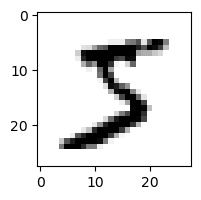

In [4]:
import numpy as np
import matplotlib.pyplot as plt
train_data0, train_label_0 = np.array(train_data[0][0]),np.array(train_data[0][1])
test_data0, test_label_0 = test_data[0][0],test_data[0][1]
train_data0 = train_data0.reshape([28,28])
plt.figure(figsize=(2,2))
plt.imshow(train_data0, cmap=plt.cm.binary)
print('train_data0 label is: ' + str(train_label_0))


## Demo numpy based auto differentiation

In [5]:
import numpy as np

class Matmul:
    def __init__(self):
        self.mem = {}
        
    def forward(self, x, W):
        h = np.matmul(x, W)
        self.mem={'x': x, 'W':W}
        return h
    
    def backward(self, grad_y):
        '''
        x: shape(N, d)
        w: shape(d, d')
        grad_y: shape(N, d')
        '''
        x = self.mem['x']
        W = self.mem['W']
        
        '''计算矩阵乘法的对应的梯度'''
        ####################
        x = self.mem['x']
        W = self.mem['W']
        grad_x = grad_y @ W.T
        grad_W = x.T @ grad_y
        
        
        ####################
        return grad_x, grad_W


class Relu:
    def __init__(self):
        self.mem = {}
        
    def forward(self, x):
        self.mem['x']=x
        return np.where(x > 0, x, np.zeros_like(x))
    
    def backward(self, grad_y):
        '''
        grad_y: same shape as x
        '''
        '''计算relu 激活函数对应的梯度'''
        ####################
        x = self.mem['x']
        grad_x = np.where(x > 0, grad_y, 0)
        
        
        ####################
        return grad_x
    


class Softmax:
    '''
    softmax over last dimention
    '''
    def __init__(self):
        self.epsilon = 1e-12
        self.mem = {}
        
    def forward(self, x):
        '''
        x: shape(N, c)
        '''
        
        ####################
        x_exp = np.exp(x)
        sum_exp = np.sum(x_exp, axis=-1, keepdims=True)
        out = x_exp / (sum_exp + self.epsilon)
        
        
        ####################
        self.mem['out'] = out
        self.mem['x_exp'] = x_exp     
        return out
    
    def backward(self, grad_y):
        '''
        grad_y: same shape as x
        '''
        s = self.mem['out']
        ####################
        s = self.mem['out']
        n, c = s.shape
        diag_tensor = np.einsum('ij,ik->ijk', s, s)
        off_diag_tensor = s[:, :, np.newaxis] * s[:, np.newaxis, :]
        tmp = np.einsum('ij,ijk->ik', grad_y, diag_tensor - off_diag_tensor)
        
        
        ####################
        return tmp
    
class Log:
    '''
    softmax over last dimention
    '''
    def __init__(self):
        self.epsilon = 1e-12
        self.mem = {}
        
    def forward(self, x):
        '''
        x: shape(N, c)
        '''
        out = np.log(x+self.epsilon)
        
        self.mem['x'] = x
        return out
    
    def backward(self, grad_y):
        '''
        grad_y: same shape as x
        '''
        x = self.mem['x']
        
        return 1./(x+1e-12) * grad_y
    


## 建立模型

In [6]:
class myModel:
    def __init__(self):
        
        self.W1 = np.random.normal(size=[28*28+1, 100])
        self.W2 = np.random.normal(size=[100, 10])
        
        self.mul_h1 = Matmul()
        self.mul_h2 = Matmul()
        self.relu = Relu()
        self.softmax = Softmax()
        self.log = Log()
                
    def forward(self, x):
        x = x.reshape(-1,28*28)
        bias = np.ones(shape=[x.shape[0], 1])
        x = np.concatenate([x, bias], axis=1)
        
        ####################
        h1 = self.mul_h1.forward(x, self.W1)
        h1_relu = self.relu.forward(h1)
        h2 = self.mul_h2.forward(h1_relu, self.W2)
        softmax_out = self.softmax.forward(h2)
        log_out = self.log.forward(softmax_out)
        self.h2_log = log_out
        
        
        ####################
            
    def backward(self, label):
        ####################
        softmax_grad = self.log.backward(-label / self.softmax.mem['out'])
        h2_grad = self.softmax.backward(softmax_grad)
        h1_relu_grad, W2_grad = self.mul_h2.backward(h2_grad)
        h1_grad = self.relu.backward(h1_relu_grad)
        _, W1_grad = self.mul_h1.backward(h1_grad)
        self.W1_grad = W1_grad
        self.W2_grad = W2_grad
        return W1_grad, W2_grad
        
        ####################
        
model = myModel()


## 计算 loss

In [7]:
def compute_loss(log_prob, labels):
     return np.mean(np.sum(-log_prob*labels, axis=1))
    
def compute_accuracy(log_prob, labels):
    predictions = np.argmax(log_prob, axis=1)
    truth = np.argmax(labels, axis=1)
    return np.mean(predictions==truth)

def train_one_step(model, x, y):
    model.forward(x)
    model.backward(y)
    model.W1 -= 1e-5* model.W1_grad
    model.W2 -= 1e-5* model.W2_grad
    loss = compute_loss(model.h2_log, y)
    accuracy = compute_accuracy(model.h2_log, y)
    return loss, accuracy

def test(model, x, y):
    model.forward(x)
    loss = compute_loss(model.h2_log, y)
    accuracy = compute_accuracy(model.h2_log, y)
    return loss, accuracy

## 实际训练

In [8]:
train_label = np.zeros(shape=[len(train_data), 10])
test_label = np.zeros(shape=[len(test_data), 10])
train_label[np.arange(len(train_data)), y_train] = 1.
test_label[np.arange(len(test_data)), y_test] = 1.

for epoch in range(50):
    loss, accuracy = train_one_step(model, x_train, train_label)
    print('epoch', epoch, ': loss', loss, '; accuracy', accuracy)
loss, accuracy = test(model, x_test, test_label)
print('test loss', loss, '; accuracy', accuracy)

epoch 0 : loss 23.171862384488627 ; accuracy 0.1102
epoch 1 : loss 23.171862384488627 ; accuracy 0.1102
epoch 2 : loss 23.171862384488627 ; accuracy 0.1102
epoch 3 : loss 23.171862384488627 ; accuracy 0.1102
epoch 4 : loss 23.171862384488627 ; accuracy 0.1102
epoch 5 : loss 23.171862384488627 ; accuracy 0.1102
epoch 6 : loss 23.171862384488627 ; accuracy 0.1102
epoch 7 : loss 23.171862384488627 ; accuracy 0.1102
epoch 8 : loss 23.171862384488627 ; accuracy 0.1102
epoch 9 : loss 23.171862384488627 ; accuracy 0.1102
epoch 10 : loss 23.171862384488627 ; accuracy 0.1102
epoch 11 : loss 23.171862384488627 ; accuracy 0.1102
epoch 12 : loss 23.171862384488627 ; accuracy 0.1102
epoch 13 : loss 23.171862384488627 ; accuracy 0.1102
epoch 14 : loss 23.171862384488627 ; accuracy 0.1102
epoch 15 : loss 23.171862384488627 ; accuracy 0.1102
epoch 16 : loss 23.171862384488627 ; accuracy 0.1102
epoch 17 : loss 23.171862384488627 ; accuracy 0.1102
epoch 18 : loss 23.171862384488627 ; accuracy 0.1102
epo